In [1]:
import matplotlib
matplotlib.use('Agg')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Helpers
import sys
sys.path.insert(0,'../../')
from helpers import *
from scipy.sparse import csr_matrix,save_npz,load_npz
from sklearn.model_selection import cross_val_score,LeaveOneOut,StratifiedKFold
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve,log_loss
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
import pickle
from sklearn.pipeline import Pipeline
# Algorithms
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV,ElasticNetCV,ElasticNet
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
import lightgbm as lgb

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Load data

In [2]:
train = pd.read_pickle('../data/feature_engineering/sub_train_count.pkl')
test = pd.read_pickle('../data/feature_engineering/sub_test_count.pkl')

In [3]:
train_X = train.drop(['sample_name','phenotype_status'],axis=1).values
test_X = test.drop(['sample_name','phenotype_status'],axis=1).values
# train_X = train[kept_TCRs].values
# test_X = test[kept_TCRs].values
train_y = train['phenotype_status'].values
test_y = test['phenotype_status'].values

In [6]:
train_X.shape

(641, 165)

In [4]:
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=31, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=180, n_jobs=1,
            oob_score=True, random_state=0, verbose=0, warm_start=False)

Optimal number of features : 147
AUROC: 0.9030974708724069 Accuracy:  0.85
Best_score: 0.9714156697161623


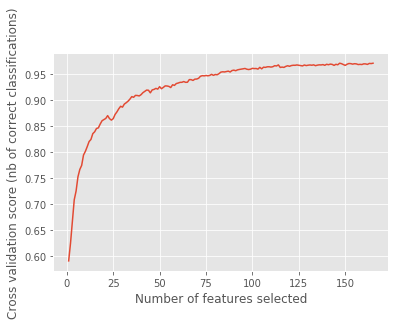

In [5]:
rfecv = RFECV(rf,cv=StratifiedKFold(10,random_state=0),scoring='roc_auc',step = 1)
rfecv.fit(train_X,train['phenotype_status'])

print("Optimal number of features : %d" % rfecv.n_features_)

print('AUROC:',roc_auc_score(test['phenotype_status'],rfecv.predict_proba(test_X)[:,1]),'Accuracy: ',accuracy_score(test['phenotype_status'],
        rfecv.predict(test_X)))
print('Best_score:',max(rfecv.grid_scores_))
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

In [6]:
rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=31, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=180, n_jobs=1,
            oob_score=True, random_state=0, verbose=0, warm_start=False)

In [ ]:
pipeline = Pipeline([
    ('rfecv', RFECV(rf,cv=StratifiedKFold(10,random_state=0),scoring='roc_auc',step = 1)),
    ('clf', rf),
])
params = {
#     'rfecv__threshold': ['0.2*mean','0.25*mean','0.3*mean','0.4*mean','median'],
    'clf__n_estimators': [100,150,200],
    'clf__max_depth': [31,30,25],
    'clf__max_features': ['auto', 'sqrt', 'log2'],
 }
cv_pipeline = GridSearchCV(estimator=pipeline, param_grid=params)
cv_pipeline.fit(X=train_X, y=train_y)
final_pipeline = cv_pipeline.best_estimator_
rfecv = final_pipeline.named_steps['rfecv']
final_classifier = final_pipeline.named_steps['clf']

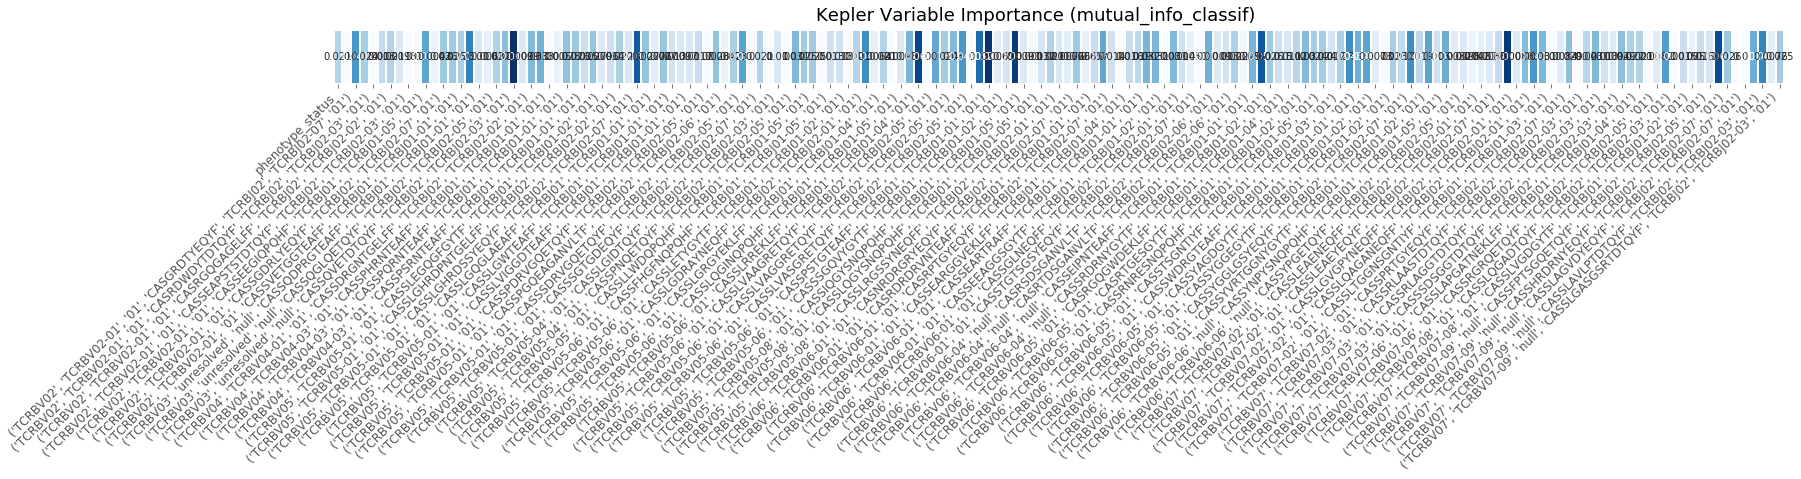

In [13]:
from sklearn.feature_selection import mutual_info_classif
kepler_mutual_information = mutual_info_classif(train_X, train_y)

plt.subplots(1, figsize=(26, 1))
sns.heatmap(kepler_mutual_information[:, np.newaxis].T, cmap='Blues', cbar=False, linewidths=1, annot=True)
plt.yticks([], [])
plt.gca().set_xticklabels(train.columns[1:], rotation=45, ha='right', fontsize=12)
plt.suptitle("Kepler Variable Importance (mutual_info_classif)", fontsize=18, y=1.2)
plt.gcf().subplots_adjust(wspace=0.2)
pass

In [19]:
kepler_mutual_information

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.0013121 ,
       0.00285935, 0.00416519, 0.00424169, 0.00425833, 0.0049672 ,
       0.0049683 , 0.00513228, 0.00566179, 0.00629777, 0.00643405,
       0.00650283, 0.00689376, 0.00725086, 0.0075766 , 0.00758876,
       0.00761604, 0.00815894, 0.00817808, 0.00837825, 0.00877756,
       0.00880297, 0.00902988, 0.00907628, 0.00940154, 0.00954125,
       0.00955665, 0.00968184, 0.0097972 , 0.00980405, 0.0098576 ,
       0.01013672, 0.01019206, 0.01033802, 0.01036259, 0.01049543,
       0.01083118, 0.01146369, 0.01152677, 0.01196236, 0.0123687 ,
       0.01256041, 0.0131156 , 0.01315483, 0.01343503, 0.01346238,
       0.01374539, 0.01376468, 0.01425625, 0.01452284, 0.01455

In [ ]:
pipeline = Pipeline([
    ('fs', SelectFromModel(rf)),
    ('estimator', lr),
])
params = {
    'fs__threshold': ['0.2*mean','0.25*mean','0.3*mean','0.4*mean','median'],
    'estimator__C': [0.5,1,5,10],
#     'clf__max_features': ['auto', 'sqrt', 'log2'],
 }
cv_pipeline = GridSearchCV(estimator=pipeline, param_grid=params)
cv_pipeline.fit(X=train_X, y=train_y)
final_pipeline = cv_pipeline.best_estimator_
final_classifier = final_pipeline.named_steps['estimator']